# 3.3. Odometry-based motion model

**Odometry** can be defined as the sum of wheel encoder pulses (see Fig. 1) to compute the robot pose. In this way, most robot bases/platforms provide some form of *odometry information*, a measurement of how much the robot has moved in reality. 

<figure style="text-align:center">
  <img src="images/fig3-3-encoder.png" width="500" alt="">
  <figcaption>Fig. 1: Example of a wheel encoder used to sum pulses and compute the robot pose.</figcaption>
</figure>

Such information is yielded by the firmware of the robotic base, which computes it at very high rate (*e.g.* at 100Hz) considering constant linear $v_t$ and angular $w_t$ velocities, and makes it available to the robot at lower rate (*e.g.* 10Hz) using a tool that we already know: the composition of poses.

<figure style="text-align:center">
  <img src="images/fig3-3-odometry_compositions.PNG" alt="">
  <figcaption>Fig. 2: Example of composition of poses based on odometry.</figcaption>
</figure>

The **odometry motion model** consists of the utilization of such information that, although technically being a measurement rather than a control, will be 
treated as a control command to simplify the modeling. Thus, the odometry commands take the form of:

$$
    u_t = f(odom_t,odom_{t-1}) = \begin{bmatrix}
            \Delta x  \\
            \Delta y \\
            \Delta \theta
        \end{bmatrix}
$$

being $odom_t$ and $odom_{t-1}$ measurements taken as control and computed from the odometry at time instants $t$ and $t-1$.

We will implement this motion model in two different forms:
- Analytical form: $u_t=[\Delta x_t, \Delta y_t, \Delta \theta_t]^T$
- Sample form: $u_t=[\theta_1,d,\theta_2]^T$

In this way, the utilization of the odometry motion model is more suitable to keep track and estimate the robot pose in contrast to the *velocity model*.

In [1]:
%matplotlib notebook

# IMPORTS
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy import stats

import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot
from utils.PlotEllipse import PlotEllipse
from utils.pause import pause
from utils.Jacobians import J1, J2
from utils.tcomp import tcomp

## 3.3.1 Analytic form

Just as we did in chapter 3.1, the analytic form of the odometry motion model uses the composition of poses to model the robot's movement, providing only a notion of how much the pose has changed, not how did it get there. 

As with the *velocity model*, the odometry one uses a gaussian distribution to represent the **robot pose**, so $x_t \sim(\overline{x}_t, \Sigma_{x_t})$, being its mean and covariance computed as:

- **Mean:**
$$\overline{x}_t 
= 
g(\overline{x}_{t-1},\overline{u}_t)
= 
\overline{x}_{t-1}\oplus \overline{u}_t \\[10pt]$$
where $u_t=[\Delta x_t, \Delta y_t, \Delta \theta_t]^T$, so: $\\[10pt]$
$$
    g(\overline{x}_{t-1},\overline{u}_t)
    = \begin{bmatrix}
        x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
        y_1 + \Delta x \sin \theta_1 - \Delta y \cos \theta_1 \\
        \theta_1 + \Delta \theta
      \end{bmatrix}
$$

- **Covariance:** 
$$\Sigma_{x_t} =  
\frac{\partial g}{\partial x_{t-1}} \cdot \Sigma_{x_{t-1}} \cdot {\frac{\partial g}{\partial x_{t-1}}}^T 
+ 
\frac{\partial g}{\partial u_{t}} \cdot \Sigma_{u_t} \cdot {\frac{\partial g}{\partial u_{t}}}^T \\[10pt]$$
where $\partial g / \partial x_{t-1}$ and $\partial g / \partial u_{t}$ are the jacobians of our motion model evaluated at the previous pose $x_{t-1}$ and the current command $u_t$:
$$
    \frac{\partial g}{\partial x_{k-1}} 
    = 
    \begin{bmatrix}
    1 & 0 & -\Delta x_k \sin \theta_{k-1}-\Delta y_k \cos \theta_{k-1} \\
    0 & 1 & \Delta x_k \cos \theta_{k-1} - \Delta y_k \sin \theta_{k-1} \\
    0 & 0 & 1
    \end{bmatrix}
    \, \, \, \,  \,  \,  \,  \,  \,  \,  \,  \, 
    \frac{\partial g}{\partial u_k}
    = 
    \begin{bmatrix}
    \cos \theta_{k-1} & -\sin \theta_{k-1} & 0  \\
    \sin \theta_{k-1} & \cos \theta_{k-1} & 0 \\
    0 & 0 & 1
    \end{bmatrix} \\[10pt]
$$
and the covariance matrix of this movement ($\Sigma_{u_t}$) is defined as seen below. Typically, it is constant during robot motion:$\\[10pt]$
$$ 
    \Sigma_{u_t} = \begin{bmatrix}
            \sigma_{\Delta x}^2 & 0 & 0\\
            0 &  \sigma_{\Delta y}^2 & 0 \\
            0 & 0 &  \sigma_{\Delta \theta}^2 
        \end{bmatrix}
$$


### **<span style="color:green"><b><i>ASSIGNMENT 1: The model in action</i></b></span>**

Similarly to the assignment 3.1, we'll move a robot along a 8-by-8 square (in meters), in increments of 2m. In this case you have to complete:

- The `step()` method to compute:
  - the new expected pose (`self.pose`), 
  - the new true pose $x_t$ (ground-truth `self.true_pose`) after adding some noise using [`stats.multivariate_normal.rvs()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) to the movement command $u$ according to `Q` (which represents $\Sigma_{u_t}$), 
  - and to update the uncertainty about the robot position in `self.P` (covariance matrix $\Sigma_{x_t}$). Note that the methods `J1()` and `J2()` already implement  $\partial g / \partial x_{t-1}$ and $\partial g / \partial u_{t}$ for you, you just have to call them with the right input parameters.
- The `draw()` method to plot:
  - the uncertainty of the pose as an ellipse centered at the expected pose, and 
  - the true position (ground-truth).

We are going to consider the following motion covariance matrix (it is already coded for you):

$$
    \Sigma_{u_t} = \begin{bmatrix}
        0.04 & 0 & 0 \\
        0 & 0.04 & 0 \\
        0 & 0 & 0.01
    \end{bmatrix}
$$

**Example**

<figure style="text-align:center">
  <img src="images/fig3-3-1.png" width="400" alt="">
  <figcaption>Fig. 2: Movement of a robot using odometry commands. <br/> Representing the expected pose (in red), the true pose (as dots) <br/> and the confidence ellipse.</figcaption>
</figure>

In [2]:
class Robot():
    """ Simulation of a robot base
    
        Attrs:
            pose: Expected pose of the robot
            P: Covariance of the current pose
            true_pose: Real pose of the robot(affected by noise)
            Q: Covariance of the movement
    """
    def __init__(self, x, P, Q):
        self.pose = x
        self.P = P
        self.true_pose = self.pose
        self.Q = Q
        
    def step(self, u):
        # TODO Update expected pose
        prev_pose = self.pose
        self.pose = tcomp(prev_pose, u)
        
        # TODO Generate true pose 
        noisy_u = np.vstack(stats.multivariate_normal.rvs(np.hstack(u), Q))
        self.true_pose = tcomp(self.true_pose, noisy_u)
        
        # TODO Update covariance
        JacF_x = J1(self.pose, u)
        JacF_u = J2(self.pose, u)

        self.P = (
            (JacF_x @ self.P @ np.transpose(JacF_x)) 
            + (JacF_u @ self.Q @ np.transpose(JacF_u))
        )
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)
        el = PlotEllipse(fig, ax, self.pose, self.P)
        ax.plot(self.true_pose[0], self.true_pose[1], 'o', color=el[0].get_color())
  

You can use the following demo to **try your new `Robot()` class**.

In [3]:
def demo_odometry_commands_analytical(robot):  
    # MATPLOTLIB
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 11])
    ax.set_ylim([-3, 11])
    plt.ion()
    plt.grid()
    plt.fill([2, 2, 6, 6],[2, 6, 6, 2],facecolor='lightgray', edgecolor='gray', linewidth=3)
    plt.tight_layout()    
    fig.canvas.draw()
    
    # MOVEMENT PARAMETERS
    nSteps = 15
    ang = -np.pi/2 # angle to turn in corners
    u = np.vstack((2., 0., 0.))
    
    # MAIN LOOP
    for i in range(nSteps):
        # change angle on corners
        if i % 4 == 3:
            u[2, 0] = ang

        #Update positions
        robot.step(u)

        # Restore angle iff changed
        if i % 4 == 3:
            u[2, 0] = 0

        # Draw every loop
        robot.draw(fig, ax)
        fig.canvas.draw()
        plt.pause(0.3)

<IPython.core.display.Javascript object>


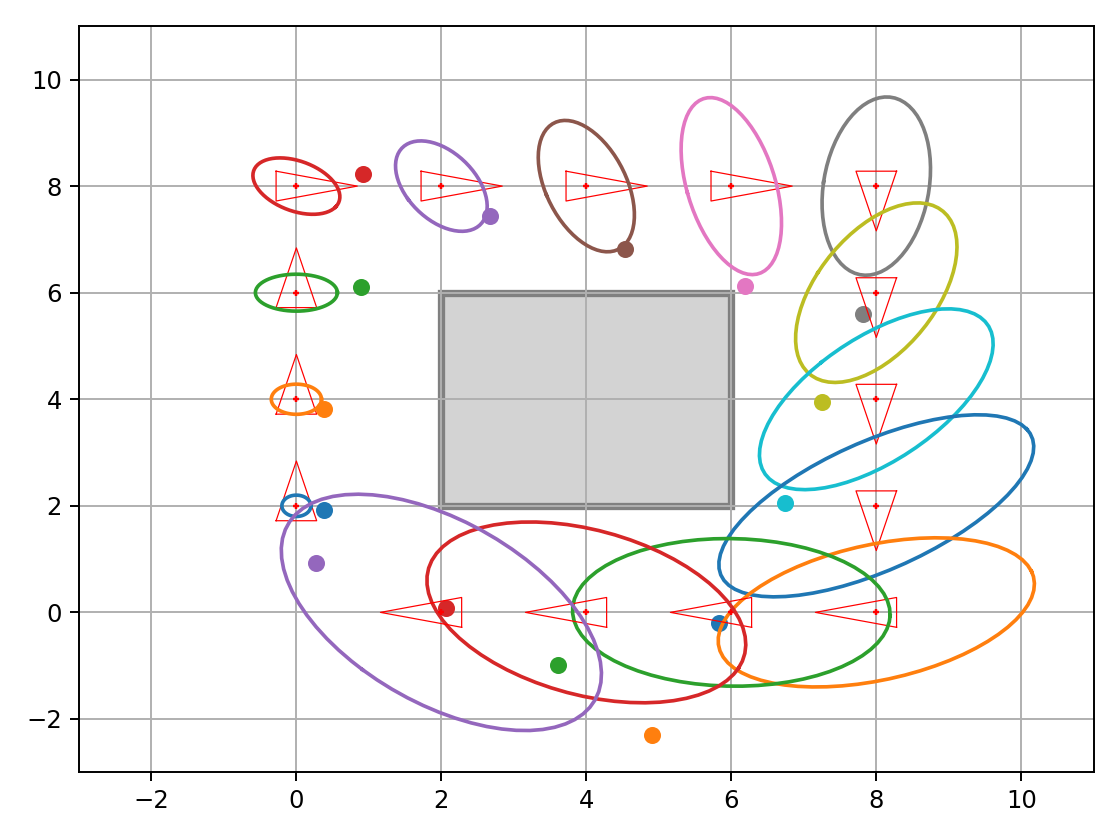

In [4]:
x = np.vstack([0., 0., np.pi/2]) # pose inicial

# Probabilistic parameters
P = np.diag([0., 0., 0.])
Q = np.diag([0.04, 0.04, 0.01])

robot = Robot(x, P, Q)
demo_odometry_commands_analytical(robot)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Once you have completed this assignment regarding the analytical form of the odometry model, **answer the following questions**:

- Which is the difference between the $g(\cdot)$ function used here, and the one in the velocity model?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Las componentes del comando de movimiento son distintas para cada modelo; la del modelo de velocidad utiliza la velocidad angular y la velocidad lineal y la del modelo odométrico está compuesto por incremento de x, y, y de theta; esto se ve reflejando en la función g, ya que en la función g para el modelo odométrico no utilizaremos ni velocidad angular ni velocidad lineal, y solo será necesario, al no tener en cuenta el radio de curvatura, considerar un solo caso al aplicar la función g.</i></p>

- How many parameters compound the motion command $u_t$ in this model?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Tres componentes: incremento de x, incremento de y e incremento de theta.</i></p>
    
- Which is the role of the Jacobians $\partial g / \partial x_{t-1}$ and $\partial g / \partial u_{t}$?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La función g no es lineal, así que los jacobianos tienen la función de aproximarla para que la pose siga una distribución normal.</i></p>

- What happens if you modify the covariance matrix $\Sigma_{u_t}$ modeling the uncertainty in the motion command $u_t$? Try different values and discuss the results. 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Como la matriz de covarianzas de la pose en el instante t se calcula en función de la matriz de covarianzas del comando de movimiento, al modificar ésta, se modificará de forma proporcional el cálculo de la matriz de covarianzas relativa a la pose, y, por ello, la incertidumbre asociada a la pose. Si aumentamos los valores de $\Sigma_{u_t}$, habrá mayor incertidumbre en la pose en el instante t; de igual forma, si los disminuimos, habrá menos incertidumbre. </i></p>

## 3.3.2 Sample form

The analytical form used above, although useful for the probabilistic algorithms we will cover in this course, does not work well for sampling algorithms such as particle filters.

The reason being, if we generate random samples from the gaussian distributions as in the previous exercise, we will find some poses that are not feasible to the non-holonomic movement of a robot, i.e. they do not correspond to a velocity command $(v, w)$ with noise.

The following *sample form* is a more realistic way to generate samples of the robot pose. In this case, the movement of the robot is modeled as a sequence of actions (see Fig 3): 

1. **Turn** ($\theta_1$): to face the destination point.
2. **Advance** ($d$): to arrive at the destination.
3. **Turn** ($\theta_2$): to get to the desired angle.

<figure style="text-align:center">
  <img src="images/fig3-3-odometry_sample_form.png"  alt="">
  <figcaption>Fig. 3: Movement of a robot using odometry commands in sampling form.</figcaption>
</figure>


So this type of order is expressed as:

$$
    u_t = \begin{bmatrix}
            \theta_1  \\
            d \\
            \theta_2
        \end{bmatrix}
$$

It can easily be generated from odometry poses $[\hat x_t, \hat y_t,\hat \theta_t]^T$ and $[\hat x_{t-1}, \hat y_{t-1},\hat \theta_{t-1}]^T$ given the following equations:

$$
    \begin{equation}
    \theta_1 =atan2(\hat y_t -\hat y_{t-1}, \hat x_t -\hat x_{t-1})- \hat \theta_{t-1} \\
    d = \sqrt{(\hat y_t -\hat y_{t-1})^2 + (\hat x_t -\hat x_{t-1})^2} \\
    \theta_2  = \hat{\theta}_t - \hat{\theta}_{t-1} - \theta_1
    \end{equation}
$$

### **<span style="color:green"><b><i>ASSIGNMENT 2: Implementing the sampling form</i></b></span>**

Complete the following cells to experience the motion of a robot using the sampling form of the odometry model. For that:

1. Implement a function that, given the previously mentioned $[\hat x_t, \hat y_t,\hat \theta_t]^T$ and $[\hat x_{t-1}, \hat y_{t-1},\hat \theta_{t-1}]^T$ generates an order $u_t = [ \theta_1, d , \theta_2 ]^T$

In [5]:
def generate_move(pose_now, pose_old):
    diff = pose_now - pose_old
    theta1 = np.arctan2(diff[1], diff[0]) - pose_old[2]
    d = np.sqrt(diff[1]**2 + diff[0]**2)
    theta2 = diff[2] - theta1
    return np.vstack((theta1, d, theta2))

**Try such function** with the code cell below:

In [6]:
generate_move(np.vstack([0., 0., 0.]), np.vstack([1., 1., np.pi/2]))

array([[-3.92699082],
       [ 1.41421356],
       [ 2.35619449]])

  Expected output for the commented example:

  ```
  array([[-3.92699082],
       [ 1.41421356],
       [ 2.35619449]])
  ```

2. Using the resulting control action $u_t = [\hat \theta_1, \hat d, \hat \theta_2]^T$ we can model its noise in the following way:

  $$
    \begin{equation}
        \theta_1 = \hat\theta_1 + \text{sample}\left(\alpha_0 \hat\theta_1^2 + \alpha_1 \hat d^2 \right) \\
        d = \hat d + \text{sample}\left(\alpha_2 \hat d^2 + \alpha_3 \left(\hat\theta_1^2 + \hat d^2 \right) \right) \\
        \theta_2 = \hat\theta_2 + \text{sample}\left(\alpha_0 \hat\theta_2^2 + \alpha_1 \hat d^2\right)
    \end{equation}
  $$

  Where $sample(b)$ generates a random value from a distribution $N(0, b)$. The vector $\alpha = [\alpha_0, \dots, \alpha_3]$ (`a` in the code), models the robot's intrinsic noise.

  The pose of the robot at the end of the movement is computed as follows:
$$
    \begin{equation}
        x_t = x_{t-1} + d \cos\left(\theta_{t-1} + \theta_1 \right) \\
        y_t = y_{t-1} + d \sin\left(\theta_{t-1} + \theta_1 \right) \\
        \theta_t = \theta_{t-1} +  \theta_1 +  \theta_2
    \end{equation}
$$
Complete the `step()` and `draw()` methods to:
  - Update the expected robot pose (`self.pose`) and generate new samples. The number of samples is set by `n_samples`, and `self.samples` is in charge of storing such samples. Each sample can be interpreted as one possible pose reached by the robot.
  - Draw the true pose of the robot (without angle) as a cloud of particles (samples of possible points which the robot can be at). 
Play a bit with different values of `a`. To improve this visualization the robot will move in increments of $0.5$ and we are going to plot the particles each 4 increments.

**Example**

<figure style="text-align:center">
  <img src="images/fig3-3-2.png" width="400" alt="">
  <figcaption>Fig. 1: Movement of a robot using odometry commands in sampling form. <br/> Representing the expected pose (in red) and the samples (as clouds of dots) </figcaption>
</figure>

In [7]:
class SampledRobot(object):
    def __init__(self, mean, a, n_samples):
        self.pose = mean
        self.a = a
        self.samples = np.tile(mean, n_samples)
        
    def step(self, u):
        # TODO Update pose
        ang = self.pose[2, 0] + u[0, 0]
        self.pose[0, 0] += u[1, 0]*np.cos(ang)
        self.pose[1, 0] += u[1, 0]*np.sin(ang)
        self.pose[2, 0] = self.pose[2, 0]+u[0, 0]+u[2, 0]
                
        # TODO Generate new samples
        sample = lambda b: stats.norm(loc=0, scale=b).rvs(size=self.samples.shape[1])
        
        u2 = u**2
        
        noisy_u = u + np.vstack((
            sample(self.a[0]*u2[0, 0]+self.a[1]*u2[1, 0]),
            sample(self.a[2]*u2[1, 0]+self.a[3]*(u2[0, 0]+u2[1, 0])),
            sample(self.a[0]*u2[2, 0]+self.a[1]*u2[1, 0])
        ))
        
        # TODO Update particles (robots) poses
        ang = self.samples[2, :] + noisy_u[0, :]
        
        self.samples[0, :] += noisy_u[1, :]*np.cos(ang)
        self.samples[1, :] += noisy_u[1, :]*np.sin(ang)
        self.samples[2, :] = self.samples[2, :]+noisy_u[0, :]+noisy_u[2, :]
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)
        ax.plot(self.samples[0, :], self.samples[1, :], '.') 

Run the following demo to **test your code**:

In [8]:
def demo_odometry_commands_sample(robot):
    # PARAMETERS
    inc = .5
    show_each = 4
    limit_iterations = 32
    
    # MATPLOTLIB
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 11])
    ax.set_ylim([-3, 11])
    plt.ion()
    plt.grid()
    plt.tight_layout()
    
    # MAIN LOOP
    robot.draw(fig, ax)
    inc_pose = np.vstack((0., inc, 0.))
    
    for i in range(limit_iterations):
        if i == 16:
            inc_pose[0, 0] = inc
            inc_pose[1, 0] = 0
            inc_pose[2, 0] = -np.pi/2
            
        u = generate_move(robot.pose+inc_pose, robot.pose)
        
        robot.step(u)
        
        if i == 16:
            inc_pose[2, 0] = 0
 
        if i % show_each == show_each-1:
            robot.draw(fig, ax)
            fig.canvas.draw()
            plt.pause(0.1)

<IPython.core.display.Javascript object>


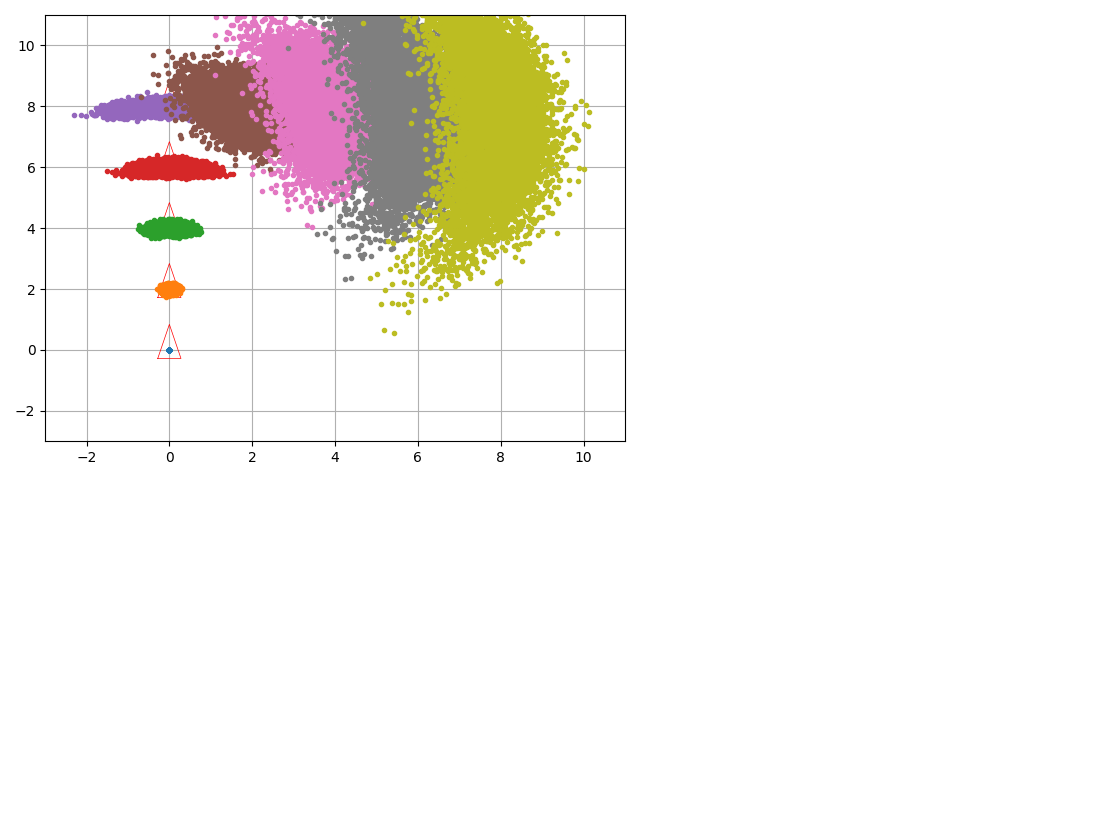

In [10]:
# RUN 
n_particles = 10000
a = np.array([.09, .09, .05, .07])
x = np.vstack((0., 0., np.pi/2))

robot = SampledRobot(x, a, n_particles)
demo_odometry_commands_sample(robot)
plt.close();

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now you are an expert in the sample form of the odometry motion model! **Answer the following questions**:

- Which is the effect of modifying the robot's intrinsic noise $\alpha$ (`a` in the code)?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>El ruido asociado al comando de movimiento aumentará y por lo tanto, la incertidumbre asociada a la pose del robot en el instante t, de manera que los valores del muestreo aparecerán más dispersos.</i></p>

- How many parameters compound the motion command $u_t$ in this model?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Tres parámetros: El giro ($\theta_1$) para orientar al robot en la dirección en la que se va a mover, el avance ($d$) para realizar el movimiento hasta la posición destino y el segundo giro ($\theta_2$) para orientar el robot en el ángulo deseado.</i></p>
    
- After moving the robot a sufficient number of times, what shape does the distribution of samples take?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>El muestro toma una forma de banana ya que son las posibles poses del robot según la incertidumbre en el movimiento y respetando el movimiento no holonómico de éste.</i></p>